In [78]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [79]:
df = pd.read_csv('/data/final_data.csv')
df.head()

,Unnamed: 0,new_text,new_label
0,0,عايزة احط عنوان,show add address
1,1,الفاتورة,invoice
2,2,عايزة اغير عنوان البيت,show change address address
3,3,اغير عنواني,change address
4,4,منيو,Menu


In [80]:
df = df.drop(['Unnamed: 0'],axis=1)

In [81]:
df.head()

,new_text,new_label
0,عايزة احط عنوان,show add address
1,الفاتورة,invoice
2,عايزة اغير عنوان البيت,show change address address
3,اغير عنواني,change address
4,منيو,Menu


In [82]:
df = df.dropna()

In [83]:
df.isnull().sum()

new_text     0
new_label    0
dtype: int64

In [84]:
df.head()

,new_text,new_label
0,عايزة احط عنوان,show add address
1,الفاتورة,invoice
2,عايزة اغير عنوان البيت,show change address address
3,اغير عنواني,change address
4,منيو,Menu


In [85]:
df.head()

,new_text,new_label
0,عايزة احط عنوان,show add address
1,الفاتورة,invoice
2,عايزة اغير عنوان البيت,show change address address
3,اغير عنواني,change address
4,منيو,Menu


In [ ]:
combined_data = pd.DataFrame(columns=['word', 'source'])
for index, row in df.iterrows():
    words_text = row['new_text'].split()
    words_label = row['new_label'].split()

    df_text = pd.DataFrame({'word': words_text, 'source': words_label})

    # Concatenate the DataFrames to the combined_data dataset
    combined_data = pd.concat([combined_data, df_text], ignore_index=True)
    # print(combined_data)

In [88]:
combined_data.tail()

,word,source
6176,3,item_number
6177,تغيرلي,change
6178,حذف,delete
6179,الجوال,phone_number
6180,وقت,late


In [89]:
# combined_data.to_csv('combined.csv',index=False)

max length for sample : 11
average length for sample: 4.890956


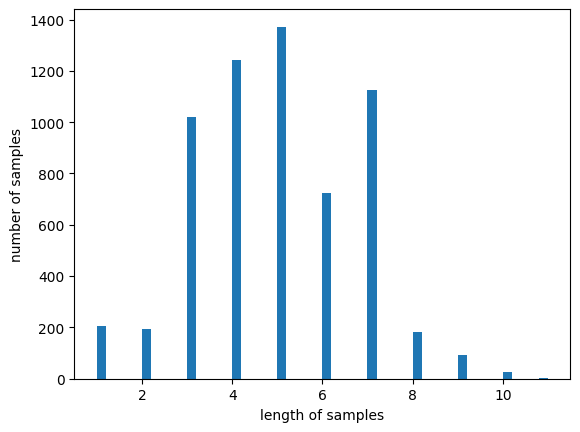

In [90]:
print('max length for sample : %d' % max(len(sentence) for sentence in combined_data['word']))
print('average length for sample: %f' % (sum(map(len, combined_data['word'])) / len(combined_data['word'])))

# Plot histogram
plt.hist([len(sentence) for sentence in combined_data['word']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [140]:
src_tokenizer = Tokenizer(oov_token='OOV')
src_tokenizer.fit_on_texts(combined_data['word'])

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(combined_data['source'])


vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('vocab_size : {}'.format(vocab_size))
print('tag_size: {}'.format(tag_size))

X_train = src_tokenizer.texts_to_sequences(combined_data['word'])
y_train = tar_tokenizer.texts_to_sequences(combined_data['source'])

print('Sentence from the first sample' , X_train[0])
print('Label of first sample:',y_train[0])

index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'
decoded = []
for index in X_train[0] : # For words converted to each integer in the first sample
     decoded.append(index_to_word[index]) # Convert to word

print('Existing sentence: {}'.format(combined_data['word'][0]))
print('Sentence with low-frequency words treated as OOV: {}'.format(decoded))

max_len = 5
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

X_train, X_test, y_train_int, y_test_int = train_test_split(X_train, y_train, test_size=.2, random_state=777)

y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

vocab_size : 129
tag_size: 26
Sentence from the first sample [4]
Label of first sample: [1]
Existing sentence: عايزة
Sentence with low-frequency words treated as OOV: ['عايزة']


In [141]:
import pickle

# Save src_tokenizer
with open('src_BiLSTM_tokenizer.pkl', 'wb') as src_file:
    pickle.dump(src_tokenizer, src_file)

# Save tar_tokenizer
with open('tar_BiLSTM_tokenizerr.pkl', 'wb') as tar_file:
    pickle.dump(tar_tokenizer, tar_file)


In [142]:
print('Size of training sample sentence: {}'.format(X_train.shape))
print('Size of training sample label: {}'.format(y_train.shape))
print('Size of test sample sentence: {}'.format(X_test.shape))
print('Size of test sample label: {}'.format(y_test.shape))

Size of training sample sentence: (4944, 5)
Size of training sample label: (4944, 5, 26)
Size of test sample sentence: (1237, 5)
Size of test sample label: (1237, 5, 26)


In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=16, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
309/309 [==============================] - 14s 20ms/step - loss: 1.1117 - accuracy: 0.8408 - val_loss: 0.0766 - val_accuracy: 0.9871
Epoch 2/3
309/309 [==============================] - 3s 8ms/step - loss: 0.0333 - accuracy: 0.9962 - val_loss: 0.0192 - val_accuracy: 0.9951
Epoch 3/3
309/309 [==============================] - 3s 8ms/step - loss: 0.0102 - accuracy: 0.9986 - val_loss: 0.0145 - val_accuracy: 0.9951


In [145]:
print("\n Test accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

39/39 [==============================] - 0s 4ms/step - loss: 0.0145 - accuracy: 0.9951

 Test accuracy: 0.9951


In [146]:
i = 10 # Index of the test sample you want to check.
# Return prediction y for the input test sample
y_predicted = model.predict(np.array([X_test[i]]))

# Convert probability vectors to integer labels.
y_predicted = np.argmax(y_predicted, axis=-1)

# Change one-hot vector to integer encoding.
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("word", "actual value", "predicted value"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
     if word != 0: # Excluding PAD values.
         print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag].upper(), index_to_ner[pred].upper()))

1/1 [==============================] - 3s 3s/step
word           |actual value|predicted value
-----------------------------------
الاوردر          : ORDER   ORDER


In [147]:
from colorama import Fore, Style

def print_predictions_colored(index_list, model, X_data, y_data, index_to_word, index_to_ner):
    for i in index_list:
        y_predicted = model.predict(np.array([X_data[i]]))

        y_predicted = np.argmax(y_predicted, axis=-1)

        labels = np.argmax(y_data[i], -1)

        print(f"{Fore.BLUE}{'Word':<17} | {Fore.GREEN}{'Actual Value':<7} | {Fore.RED}{'Predicted Value':<7}{Style.RESET_ALL}")
        print(50 * "-")

        for word, tag, pred in zip(X_data[i], labels, y_predicted[0]):
            if word != 0:  # Excluding PAD values.
                actual_value = index_to_ner[tag].upper()
                predicted_value = index_to_ner[pred].upper()

                # Use different colors for correct and incorrect predictions
                color_actual = Fore.GREEN if actual_value == predicted_value else Fore.RED
                color_predicted = Fore.GREEN if actual_value == predicted_value else Fore.RED

                print(f"{color_actual}{index_to_word[word]:<17} | {color_actual}{actual_value:<7} | {color_predicted}{predicted_value:<7}{Style.RESET_ALL}")

index_list = [43, 45, 80, 90]
print_predictions_colored(index_list, model, X_test, y_test, index_to_word, index_to_ner)


1/1 [==============================] - 0s 21ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
الطلبات           | ORDER   | ORDER  
1/1 [==============================] - 0s 18ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
الاوردرات         | ORDER   | ORDER  
1/1 [==============================] - 0s 18ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
مع                | ADD     | ADD    
1/1 [==============================] - 0s 18ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
عايزة             | SHOW    | SHOW   


In [150]:
def predict_labels(input_text, src_tokenizer, model, index_to_word, index_to_ner, max_len):
    # Preprocess input text
    input_text = input_text.split()
    input_sequence = src_tokenizer.texts_to_sequences([input_text])
    padded_sequence = pad_sequences(input_sequence, padding='post', maxlen=max_len)

    # Make predictions
    predictions = model.predict(np.array(padded_sequence))

    # Convert probability vectors to integer labels
    predicted_labels = np.argmax(predictions, axis=-1)

    # Print the results
    print("{:15}|{}".format("Word", "Predicted Label"))
    print(30 * "-")

    for word, pred in zip(input_text, predicted_labels[0]):
        print("{:15}: {}".format(word, index_to_ner[pred].upper()))

# Example usage
user_input = 'عايزة اضيف عنوان'
predict_labels(user_input, src_tokenizer, model, index_to_word, index_to_ner, max_len)


1/1 [==============================] - 0s 78ms/step
Word           |Predicted Label
------------------------------
عايزة          : SHOW
اضيف           : ADD
عنوان          : ADDRESS


#CRF

In [ ]:
# !pip install seqeval
#keras-crf


In [151]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

embedding_dim = 30
hidden_units = 20
dropout_ratio = 0.3

sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train_int, batch_size=128, epochs=30, validation_split=0.1, callbacks=[mc, es])


Epoch 1/30
35/35 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.6963 - loss: 14.9138
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.77455, saving model to bilstm_crf/cp.ckpt
35/35 [==============================] - 10s 104ms/step - decode_sequence_accuracy: 0.6963 - loss: 14.8620 - val_decode_sequence_accuracy: 0.7745 - val_loss: 12.8716
Epoch 2/30
35/35 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.7702 - loss: 8.1022
Epoch 2: val_decode_sequence_accuracy did not improve from 0.77455
35/35 [==============================] - 2s 54ms/step - decode_sequence_accuracy: 0.7702 - loss: 8.0156 - val_decode_sequence_accuracy: 0.7745 - val_loss: 4.9907
Epoch 3/30
33/35 [===========================>..] - ETA: 0s - decode_sequence_accuracy: 0.7709 - loss: 4.3384
Epoch 3: val_decode_sequence_accuracy did not improve from 0.77455
35/35 [==============================] - 1s 27ms/step - decode_sequence_accuracy: 0.7702 - loss: 4.3181

In [153]:
model.load_weights('bilstm_crf/cp.ckpt')

i = 108 #
y_predicted = model.predict(np.array([X_test[i]]))[0] #
labels = np.argmax(y_test[i], -1) #

print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: #pad
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))


1/1 [==============================] - 0s 21ms/step
-----------------------------------
عايزة            : show    show


In [157]:
from colorama import Fore, Style

def print_predictions_colored(index_list, model, X_data, y_data, index_to_word, index_to_ner):
    for i in index_list:
        y_predicted = model.predict(np.array([X_data[i]]))[0]

        # Convert probability vectors to integer labels.
        # y_predicted = np.argmax(y_predicted, axis=-1)

        # Change one-hot vector to integer encoding.
        labels = np.argmax(y_data[i], -1)

        print(f"{Fore.BLUE}{'Word':<17} | {Fore.GREEN}{'Actual Value':<7} | {Fore.RED}{'Predicted Value':<7}{Style.RESET_ALL}")
        print(50 * "-")

        for word, tag, pred in zip(X_data[i], labels, y_predicted[0]):
            if word != 0:  # Excluding PAD values.
                actual_value = index_to_ner[tag].upper()
                predicted_value = index_to_ner[pred].upper()

                # Use different colors for correct and incorrect predictions
                color_actual = Fore.GREEN if actual_value == predicted_value else Fore.RED
                color_predicted = Fore.GREEN if actual_value == predicted_value else Fore.RED

                print(f"{color_actual}{index_to_word[word]:<17} | {color_actual}{actual_value:<7} | {color_predicted}{predicted_value:<7}{Style.RESET_ALL}")

index_list = [43, 45, 80, 90]
print_predictions_colored(index_list, model, X_test, y_test, index_to_word, index_to_ner)


1/1 [==============================] - 0s 38ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
الطلبات           | ORDER   | ORDER  
1/1 [==============================] - 0s 23ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
الاوردرات         | ORDER   | ORDER  
1/1 [==============================] - 0s 21ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
مع                | ADD     | ADD    
1/1 [==============================] - 0s 20ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
عايزة             | SHOW    | SHOW   


In [166]:
print("\n Test accuracy: %.4f" % (model.evaluate(X_test, y_test_int)[0]))

39/39 [==============================] - 0s 9ms/step - decode_sequence_accuracy: 0.9989 - loss: 0.0311

 Test accuracy: 0.9989


In [ ]:
import pickle

# Save src_tokenizer
with open('src_tokenizer.pkl', 'wb') as src_file:
    pickle.dump(src_tokenizer, src_file)

# Save tar_tokenizer
with open('tar_tokenizer.pkl', 'wb') as tar_file:
    pickle.dump(tar_tokenizer, tar_file)


In [ ]:
import os
import tensorflow as tf
import tensorflow.keras.backend as K

tf.keras.models.save_model(model, os.path.join('models', 'NER3_MODEL.h5'))

# K.clear_session()

unet = tf.keras.models.load_model(os.path.join('models', 'NER3_MODEL.h5'), compile=False)
# optimizer = tf.keras.optimizers.Adam(lr=0.0001)

<ipython-input-519-8e0656a332fb>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, os.path.join('models', 'NER3_MODEL.h5'))


#Test2


In [ ]:
df['new_text'] = df['new_text'].apply(lambda x: x.split())
df['new_label'] = df['new_label'].apply(lambda x: x.split())

In [ ]:
df.head()

,new_text,new_label
0,"['عايزة', 'احط', 'عنوان']","['show', 'add', 'address']"
1,['الفاتورة'],['invoice']
2,"['عايزة', 'اغير', 'عنوان', 'البيت']","['show', 'change', 'address', 'address']"
3,"['اغير', 'عنواني']","['change', 'address']"
4,['منيو'],['Menu']


In [ ]:
df.head()

,new_text,new_label
0,"['عايزة', 'احط', 'عنوان']","['show', 'add', 'address']"
1,['الفاتورة'],['invoice']
2,"['عايزة', 'اغير', 'عنوان', 'البيت']","['show', 'change', 'address', 'address']"
3,"['اغير', 'عنواني']","['change', 'address']"
4,['منيو'],['Menu']


max length for sample : 68
average length for sample: 15.714898


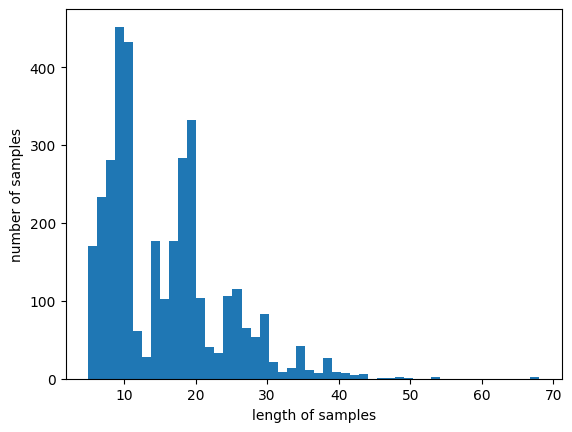

In [ ]:
print('max length for sample : %d' % max(len(sentence) for sentence in df['new_text']))
print('average length for sample: %f' % (sum(map(len, df['new_text'])) / len(df['new_text'])))

# Plot histogram
plt.hist([len(sentence) for sentence in df['new_text']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
vocab_size = 100
src_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
src_tokenizer.fit_on_texts(df['new_text'])

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(df['new_label'])

In [ ]:
import pickle

# Save src_tokenizer
with open('src_tokenizer.pkl', 'wb') as src_file:
    pickle.dump(src_tokenizer, src_file)

# Save tar_tokenizer
with open('tar_tokenizer.pkl', 'wb') as tar_file:
    pickle.dump(tar_tokenizer, tar_file)


In [ ]:
# df.to_csv('final_model.csv',index=False)

In [ ]:
tag_size = len(tar_tokenizer.word_index) + 1
print('vocab_size : {}'.format(vocab_size))
print('tag_size: {}'.format(tag_size))

vocab_size : 100
tag_size: 27


In [ ]:
X_train = src_tokenizer.texts_to_sequences(df['new_text'])
y_train = tar_tokenizer.texts_to_sequences(df['new_label'])

In [ ]:
print('Sentence from the first sample' , X_train[0])
print('Label of first sample:',y_train[0])

Sentence from the first sample [4, 65, 5]
Label of first sample: [1, 10, 4]


In [ ]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [ ]:
decoded = []
for index in X_train[0] : # For words converted to each integer in the first sample
     decoded.append(index_to_word[index]) # Convert to word

print('Existing sentence: {}'.format(df['new_text'][0]))
print('Sentence with low-frequency words treated as OOV: {}'.format(decoded))

Existing sentence: ['عايزة', 'احط', 'عنوان']
Sentence with low-frequency words treated as OOV: ["'عايزة'", "'احط'", "'عنوان'"]


In [ ]:
max_len = 20
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)


In [ ]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)


In [ ]:
print('Size of training sample sentence: {}'.format(X_train.shape))
print('Size of training sample label: {}'.format(y_train.shape))
print('Size of test sample sentence: {}'.format(X_test.shape))
print('Size of test sample label: {}'.format(y_test.shape))

Size of training sample sentence: (2797, 20)
Size of training sample label: (2797, 20, 27)
Size of test sample sentence: (700, 20)
Size of test sample label: (700, 20, 27)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

embedding_dim = 10
hidden_units = 10

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
175/175 [==============================] - 61s 42ms/step - loss: 3.0594 - accuracy: 0.2766 - val_loss: 2.5559 - val_accuracy: 0.2498
Epoch 2/10
175/175 [==============================] - 2s 12ms/step - loss: 2.1758 - accuracy: 0.4023 - val_loss: 1.7888 - val_accuracy: 0.5052
Epoch 3/10
175/175 [==============================] - 2s 13ms/step - loss: 1.5321 - accuracy: 0.6156 - val_loss: 1.2647 - val_accuracy: 0.7310
Epoch 4/10
175/175 [==============================] - 2s 11ms/step - loss: 1.0841 - accuracy: 0.7820 - val_loss: 0.8933 - val_accuracy: 0.8255
Epoch 5/10
175/175 [==============================] - 2s 14ms/step - loss: 0.7649 - accuracy: 0.8800 - val_loss: 0.6421 - val_accuracy: 0.8919
Epoch 6/10
175/175 [==============================] - 3s 15ms/step - loss: 0.5530 - accuracy: 0.9106 - val_loss: 0.4712 - val_accuracy: 0.9215
Epoch 7/10
175/175 [==============================] - 2s 13ms/step - loss: 0.4091 - accuracy: 0.9303 - val_loss: 0.3582 - val_accuracy: 0.934

In [ ]:
print("\n Test accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

22/22 [==============================] - 0s 8ms/step - loss: 0.1929 - accuracy: 0.9672

 Test accuracy: 0.9672


In [ ]:
i = 10 # Index of the test sample you want to check.
# Return prediction y for the input test sample
y_predicted = model.predict(np.array([X_test[i]]))

# Convert probability vectors to integer labels.
y_predicted = np.argmax(y_predicted, axis=-1)

# Change one-hot vector to integer encoding.
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("word", "actual value", "predicted value"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
     if word != 0: # Excluding PAD values.
         print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag].upper(), index_to_ner[pred].upper()))

1/1 [==============================] - 2s 2s/step
word           |actual value|predicted value
-----------------------------------
'تغير'           : 'CHANGE' 'CHANGE'
'عنوان'          : 'ADDRESS' 'ADDRESS'
'البيت'          : 'ADDRESS' 'ADDRESS'


In [ ]:
# !pip install colorama

In [ ]:
from colorama import Fore, Style

def print_predictions_colored(index_list, model, X_data, y_data, index_to_word, index_to_ner):
    for i in index_list:
        y_predicted = unet.predict(np.array([X_data[i]]))

        # Convert probability vectors to integer labels.
        y_predicted = np.argmax(y_predicted, axis=-1)

        labels = np.argmax(y_data[i], -1)

        print(f"{Fore.BLUE}{'Word':<17} | {Fore.GREEN}{'Actual Value':<7} | {Fore.RED}{'Predicted Value':<7}{Style.RESET_ALL}")
        print(50 * "-")

        for word, tag, pred in zip(X_data[i], labels, y_predicted[0]):
            if word != 0:  # Excluding PAD values.
                actual_value = index_to_ner[tag].upper()
                predicted_value = index_to_ner[pred].upper()

                color_actual = Fore.GREEN if actual_value == predicted_value else Fore.RED
                color_predicted = Fore.GREEN if actual_value == predicted_value else Fore.RED

                print(f"{color_actual}{index_to_word[word]:<17} | {color_actual}{actual_value:<7} | {color_predicted}{predicted_value:<7}{Style.RESET_ALL}")

index_list = [43, 45, 80, 90]
print_predictions_colored(index_list, model, X_test, y_test, index_to_word, index_to_ner)


1/1 [==============================] - 0s 20ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
'اسجل'            | 'UPDATE | 'PREVIOUS'
'العنوان'         | DATA'   | NUMBER'
1/1 [==============================] - 0s 19ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
'اوردر'           | 'ORDER' | 'ORDER'
'رقم'             | 'PHONE  | 'ADDRESS'
1/1 [==============================] - 0s 18ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
'بيتزا'           | 'ITEMNAME' | 'CHANGE'
'سوبر'            | 'ITEMNAME' | 'CHANGE'
'سوبريم'          | 'ITEMNAME' | 'CHANGE'
1/1 [==============================] - 0s 24ms/step
Word              | Actual Value | Predicted Value
--------------------------------------------------
'منيو'            | 'MENU'  | 'PHONE 


In [ ]:
import os
import tensorflow as tf
import tensorflow.keras.backend as K

tf.keras.models.save_model(model, os.path.join('models', 'NER2_MODEL.h5'))

# K.clear_session()

unet = tf.keras.models.load_model(os.path.join('models', 'NER2_MODEL.h5'), compile=False)
# optimizer = tf.keras.optimizers.Adam(lr=0.0001)

<ipython-input-425-bebaee4cffca>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, os.path.join('models', 'NER2_MODEL.h5'))


In [ ]:
df = pd.read_csv('/data/final_model.csv') # labeled show --> عايزه
df.head()

,new_text,new_label
0,"['عايزة', 'احط', 'عنوان']","['show', 'add', 'address']"
1,['الفاتورة'],['invoice']
2,"['عايزة', 'اغير', 'عنوان', 'البيت']","['show', 'change', 'address', 'address']"
3,"['اغير', 'عنواني']","['change', 'address']"
4,['منيو'],['Menu']


In [ ]:
import pickle

# Load src_tokenizer
with open('/data/src_tokenizer.pkl', 'rb') as src_file:
    src_tokenizer = pickle.load(src_file)

# Load tar_tokenizer
with open('/dara/tar_tokenizer.pkl', 'rb') as tar_file:
    tar_tokenizer = pickle.load(tar_file)
